In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

import seaborn as sns
import numpy as np

from sklearn import set_config ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO
set_config(display = 'diagram') ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO

import joblib
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, cohen_kappa_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from  sklearn.base import clone ## Copiar un pipeline
import xgboost as xgb
import wandb as wb

import warnings
warnings.filterwarnings("ignore")

In [ ]:
! python --version

In [2]:
train = pd.read_csv('Train.csv')

In [ ]:
train.head(2)

In [ ]:
train.info()

In [3]:
## Realizamos una copia del dataset original en caso de volver a ocupar esta versión sin cambios.
train_original = train.copy()

In [4]:
## Se verifica si hay datos duplicados
train.loc[train.duplicated()]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


In [5]:
## Se elimina la variable ID, no es relevante para el análisis
train.drop('ID', axis = 1, inplace = True)

## Limpieza y EDA

### a. Control de calidad de los datos.
En esta sección se realiza una revisión del tipo de variables y el número de datos faltantes en el data set de entrenamiento.

In [ ]:
ax = train.isnull().sum()[train.isnull().sum()>0].sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set_title('Variables con valores nulos')
ax.get_xaxis().set_visible(False)
plt.show()

In [ ]:
train.isnull().sum(axis = 1).value_counts()

* En el control de calidad de los datos, se encuentra que el dataset consta de 8.608 observaciones y 11 variables, las cuales todas tienen el tipo de variable esperado. 

* Con respecto a los datos faltantes, la variable ***Work_Experience*** es la que mayor cantidad de nulos tiene (829), seguido de ***Family_Size*** (335).

* En cuanto a el número de nulos por observación se encuentra que, existen 6.665 registros completos, 1.244 registros con un dato faltante en 1 columna, 140 registros con datos faltantes en 2 columnas y 19 registros con al menos 3 columnas sin dato.

In [6]:
## SE DEFINE FUNCIÓN PARA SEPARAR LAS VARIABLES CATEGÓRICAS, NUMÉRICAS Y LA DEPENDIENTE
def SepararNumCate(df : pd.DataFrame):
    '''Returns a triplet with column names (numerical, categorical, target)
    '''
    numerical = df.select_dtypes(include = 'number').columns.to_list()
    categorical = df.select_dtypes(exclude = 'number').columns.to_list()
    categorical.remove('Segmentation') ## REMOVES THE TARGET VARIABLE
    target = ['Segmentation']
    return numerical, categorical, target


num_idx, categ_idx, target_idx = SepararNumCate(train)

In [ ]:
## Identificar los valores únicos de las variables categóricas
for i in train[categ_idx + target_idx].columns:
    print(f'Categorías de la variable "{i}" ',train[i].unique(),'\n')

Para elegir qué se va a realizar con respecto a los valores faltantes se proponen 3 estrategias que se pondrán a prueba:

> - 1. Un data set de entrenamiento eliminando todos las observaciones que tengan al menos 1 dato faltante, lo que representa quedarse con un 75% del data set de entrenamiento inicial.

> - 2. Un data set de entrenamiento donde se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor del dato, mediante algún método de imputación.

> - 3. Un data set donde no se elimina ningún registro, se asigna el valor de los datos por algún método de imputación.


**Definimos los pipelines y la función por la cual va a pasar cada uno de los dataset de las anteriores estrategias**

In [7]:
### Pipelines

numerical_pipeline = Pipeline( steps = [
    ('scaler',StandardScaler())
])

categ_pipeline = Pipeline( steps = [
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

## ColumnTransformer
columnsTransf = ColumnTransformer(transformers = [
                    ('numerical_pl',numerical_pipeline,num_idx),
                    ('categorical_pl',categ_pipeline,categ_idx)
                            ],
                    remainder = 'drop'
                                )

rf_model = RandomForestClassifier(random_state = 123)
lr_model = LogisticRegression(random_state = 123)
nb_model = GaussianNB()
kn_clf_model = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier(random_state = 123)


### Diccionario que contiene todos los pipelines
pl_dict = { 'RandomForest' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',rf_model)
                                        ]),
            'LogisticRegression' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',lr_model)
                                        ]),
            'NaiveBayes' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',nb_model)
                                         ]),
            'KNeighborsClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',kn_clf_model)
                                         ]),
            'XGBClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',xgb_clf)
                                         ])                                         
           }

## Crear el pipeline para la imputación
num_imputer = Pipeline(steps = [
        ('num_imputer',SimpleImputer(strategy = 'median')),
])

cat_imputer = Pipeline(steps = [
    ('cat_imputer',SimpleImputer(strategy = 'most_frequent'))
])

columnImputer = ColumnTransformer(transformers = [
    ('Numerical',num_imputer,num_idx),
    ('Categorical', cat_imputer, categ_idx)
                                ], 
            remainder = 'passthrough' ## En este caso no se utiliza el passthrough porque necesitamos nuestra variable objetivo, ya que este pipeline es sólo para transformar columna
)

imputer_pipe = Pipeline(steps=[
    ('columns_transf',columnImputer)
])

def ImputersTest(df : pd.DataFrame,  numerical_columns : list, 
                 categorical_columns : list, target : str, model : str): 
    if model in pl_dict.keys():
        pipe = clone(pl_dict.get(model))
        print(f"Accuracy with CV : {cross_val_score(pipe,df[numerical_columns + categorical_columns], df[target], cv = 5, scoring = 'accuracy').mean()}")
        return None
    else:
        print(f'{model} no es un modelo implementado, las opciones son {list(pl_dict.keys())}')

### Estrategia 1

No hacer ningún tratamiento de imputación, se eliminan las filas que contengan NA's.

In [8]:
train1 = train.dropna( axis = 0).copy()

In [9]:
ImputersTest(train1 ,num_idx, categ_idx, target_idx, 'RandomForest')

Accuracy with CV : 0.48012003000750186


### Estrategia 2

In [10]:
## Se eliminan las filas que tienen datos faltantes en 2 o más de sus columnas
train2 = train.drop(train.loc[train.isna().sum(axis = 1) >= 2].index).copy()

In [11]:
train2_imp = pd.DataFrame(clone(imputer_pipe).fit_transform(train2), columns = num_idx + categ_idx + target_idx)

In [ ]:
ImputersTest(train2_imp,num_idx,categ_idx,target_idx,'RandomForest')

### Estrategia 3

In [ ]:
train3 = train.copy()

In [ ]:
train3_imp = pd.DataFrame(clone(imputer_pipe).fit_transform(train3), columns = num_idx + categ_idx + target_idx)

In [ ]:
ImputersTest(train3_imp,num_idx,categ_idx,target_idx,'RandomForest')

De las 3 estrategias propuestas y evaluadas, todas presentaron un accuracy similar, No obstante si se eliminan todos los datos faltantes (estrategia 1) se perdería alrededor del 17% de las observaciones, mientras que si se eliminan sólo aquellos registros cuyas observaciones tengan nulos en 2 o más variables se perdería alrededor del 2% del dataset original. Por lo cual, se realizará el resto del ejercicio con el dataset derivado de la estrategia 2.

In [12]:
## Definimos el dataset imputado para seguir trabajando el resto del ejercicio
del train ## se elimina el df que tenía este nombre

train = train2_imp.copy().astype(train1.dtypes.to_dict()) ## Se le asignan el tipo de variables de uno de los datasets ya que con la imputación todas las variables quedan como tipo object.

### b. Visualización de la información

* **Balanceo de la variable dependiente**

  Cada una de las categorías de la variable Segmentation contiene alrededor del 25% de las observaciones, por lo que al dataset no hay que realizarle procesos de balanceo.

In [ ]:
ax = train.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar')
ax.get_yaxis().set_visible(False)
labels = (train.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis = 'x', rotation = 0)  ## ROTAR LAS ETIQUETAS DEL EJE X
for container in ax.containers:
    ax.bar_label(container, labels = labels)
plt.show()

DESCRIPCIÓN VARIABLES NUMÉRICAS VS VARIABLE DEPENDIENTE
* **Segmentación vs Edad:**

    En los siguientes gráficos se observa que el grupo D, tiene en promedio una edad menor que el resto de grupos, siendo esta alrededor de los 32 años. Los 3 grupos restantes tienen una edad promedio muy cercana a los 50 años.

* **Segmentación vs Experiencia laboral**

    En la gráfica siguiente se observa que el promedio de experiencia laboral para todas las categorías de Segmentation se encuentra entre los 2 y 3 años, también es posible identificar que el grupo D es el que más experiencia tiene puesto que un 75% de los individuos tienen una experiencia laboral de 6 años o menos, y el grupo C es el que menos experiencia tiene ya que el 75% de los individuos tienen una experiencia de 3 años o menos.


* **Segmentation vs Family Size**

  El tamaño del núcleo familiar tiene una distribución similar para los segmentos B, C y D, donde el 75% de los individuos cada uno de estos grupos tiene un núcleo familiar conformado por 4 o menos personas, por otra parte el núcleo familiar del Segmento A es más reducido donde el 75% de los individuos tienen un núcleo familiar de 3 o menos personas.

In [ ]:
fig, (ax1 ,ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
sns.boxplot(data = train, x = 'Segmentation', y = 'Age',order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True, palette = 'vlag')
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True,palette="vlag")
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax3, showmeans = True, palette="vlag")

#//TODO ...poner la media como texto en cada uno de los boxplots
# Calcular la media por categoría
# means = train.groupby('Segmentation')[['Age', 'Work_Experience', 'Family_Size']].mean().values

# Agregar líneas para la media y la mediana
#for i in range(len(train.Segmentation.sort_values().unique())):
 #   plt.text(i, means[i], f'{means[i]:.2f}', ha='center', va='bottom', color='blue', fontsize=8)

plt.show()


* **Género vs Segmentación**

   Con respecto a la distribución del género por Segmentación, la participación en todos los grupos de ambos géneros es similar a excepción del grupo D, donde la participación de los hombres es casi del 60%.

* **Ever_Married vs Segmentación**
  
  La variable categórica que toma en cuenta si el individuo ha estado casado alguna vez presenta la siguiente distribución: en los grupos A, B y C la mayoría de personas han estado casados, teniendo una mayor participación elos grupos A y B alcanzando casi el 80%. El grupo D por el contrario más del 70% de los individuos no han estado casados, este grupo como se vió en anteriores gráficas es el grupo con menor promedio de edad.
  
* **Graduated vs Segmentation**

    La variable binaria que captura si el individuo se graduó sigue el comportamiento siguiente diferenciándola por la Segmentación: En los grupos A, B y C más del 60% son graduados, caso contrario en el grupo D donde poco más del 60% de los individuos no son graduados.

* **Spending_Score vs Segmentation**
    La variable categórica que captura si el puntaje de consumo es bajo, medio o alto presenta la siguiente distribución: Los grupos A, B y D predominan las personas que tienen un consumo bajo, siendo en el grupo D casi la totalidad de personas que tienen un consumo bajo, por su parte en el grupo C  predomina el consumo promedio con un poco más del 40%.

* **Profession vs Segmentation**
  
  Con respecto a la profesión del cliente:
    - El grupo A la mayor participación la tienen los artistas con casi el 30% de los individuos seguido de los profesionales del entretenimiento.
    - El grupo B la mayor participación la tienen los artistas con más del 40% de los individuos seguido por los profesionales del entretenimiento.
    - El grupo C la mayor participación la tienen los artistas con más del 50% de los individuos seguido por los ejecutivos.
    - El grupo D la mayor participación la tienen los profesionales de la salud con más del 40% seguido por los doctores y profesionales del entretenamiento.
     
* **Var_1 vs Segmentation**

  Con respecto a una categoría anónima que se le asigna a cada cliente la categoría 6 tiene la mayor participación en todos los segmentos con más del 60% de todos los individuos para los grupos A, B y C, y más del 50% en el grupo D

In [ ]:
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6)) = plt.subplots(3,2, figsize = (18,12), sharey = True)
pd.crosstab(train.Segmentation,train.Gender,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black',colormap= 'vlag')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', title = 'Gender')
ax1.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Ever_Married,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black', colormap= 'vlag')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
ax2.legend(loc = 'upper left',  title = 'Gender')
ax2.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Graduated,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax3, edgecolor = 'black',colormap= 'vlag')
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax3.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax3.legend(loc = 'upper left', title = 'Ever_Married')
ax3.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Spending_Score,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax4, edgecolor = 'black',colormap= 'vlag')
ax4.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax4.tick_params(axis='x', rotation = 0) 
ax4.legend(loc = 'upper left', title = 'Spending_Score')
ax4.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Profession,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax5, edgecolor = 'black',colormap= 'vlag')
ax5.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax5.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax5.legend(loc = 'upper left', ncols = 3, title = 'Profession')
ax5.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Var_1,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax6, edgecolor = 'black',colormap= 'vlag')
ax6.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax6.tick_params(axis='x', rotation=0) 
ax6.legend(loc = 'upper left', ncols = 3)
ax6.set_xlabel(None)
fig.suptitle('Variables categóricas vs variable objetivo', fontsize = 20)
plt.show()

In [ ]:
def calcular_coeficiente_contingencia(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        n = tabla_contingencia.values.sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(len(tabla_contingencia.index) - 1, len(tabla_contingencia.columns) - 1)))
        resultados.append([col, coef_contingencia])
    df_resultado = pd.DataFrame(resultados, columns=['Variable', 'Coeficiente de Contingencia'])
    df_resultado.sort_values(by='Coeficiente de Contingencia', ascending=False, inplace=True)
    df_resultado.reset_index(drop=True, inplace=True)
    return df_resultado.round(4)

**Interpretación asociación entre variables categóricas independientes y variable objetivo**
 - Todas las variables tienen un coeficiente menor a 0.6, por lo que ninguna presenta una asociación relativamente intensa con la variable objetivo. Sin embargo, la variable Ever_Married es la que mayor coeficiente de asociación tiene.


In [ ]:
calcular_coeficiente_contingencia(train1,categ_idx, 'Segmentation')

### c. Extracción de información de los datos

### d. Comprensión y limpieza de datos


### e. Entrenar el modelo de clasificación

In [30]:
## Definir protocolos de evaluación
def ClfScores(model, x_train,y_train,x_test,y_test):
    '''
    model : must be a previously fitted estimator
    '''
    yTest_pred = model.predict(x_test)
    yTrain_pred = model.predict(x_train)
    roc_auc_train = roc_auc_score(y_train, yTrain_pred,  multi_class='ovr')
    roc_auc_test = roc_auc_score(y_test, yTest_pred,  multi_class='ovr')
    # avg_prec_test = average_precision_score(y_test, yTest_pred)
    # avg_prec_train = average_precision_score(y_train, yTrain_pred)
    acc_test = accuracy_score(y_test, yTest_pred)
    acc_train = accuracy_score(y_train, yTrain_pred)
    ck_train = cohen_kappa_score(y_train, yTrain_pred)
    ck_test = cohen_kappa_score(y_test, yTest_pred)
    precision_train = precision_score(y_train, yTrain_pred, average = None)
    precision_test = precision_score(y_test, yTest_pred, average = None)
    rec_train = recall_score(y_train, yTrain_pred, average = None)
    rec_test = recall_score(y_test, yTest_pred, average = None)
    metrics = {
                'Accuracy test' : acc_test,
                'Accuracy train' : acc_train,
                'ROC_auc_test' : roc_auc_test,
                'ROC_auc_train' : roc_auc_train,
                # 'Avg precision test' : avg_prec_test,
                # 'Avg precision train' : avg_prec_train,
                'Cohen Kappa train' :  ck_train,
                'Cohen Kappa test' :  ck_test,
                'Precision train' : precision_train,
                'Precision test' : precision_test,
                'Recall train' :  rec_train,
                'Recall test'  :  rec_test
    }
    for i in metrics.keys():
        print(i,' : ', metrics.get(i))
    return None

**Rama Yuliana**

In [ ]:
df_test = pd.read_csv("Test.csv")
df_test.info()

In [ ]:
## Se verifica si hay datos duplicados
df_test.loc[df_test.duplicated()]
## Se elimina la variable ID, no es relevante para el análisis
df_test.drop('ID', axis = 1, inplace = True)

In [ ]:
# Separar el data set de test con la función
num_idx_test, categ_idx_test, target_idx_test = SepararNumCate(df_test)

In [ ]:
# Usar el pipeline de  imputación y transformación 
test_clean = pd.DataFrame(clone(imputer_pipe).fit_transform(df_test), columns = num_idx_test + categ_idx_test + target_idx_test)

In [ ]:
## HoldOut
X_train = train[num_idx + categ_idx]
y_train = train[target_idx]
X_test = test_clean[num_idx_test + categ_idx_test]
y_test = test_clean[target_idx_test]

In [ ]:
target_transf = LabelEncoder()  ## Es necesario etiquetar la variable objetivo, algunos algoritmos lo requieren (XGBClassifier)
y_train = target_transf.fit_transform(y_train)
y_test = target_transf.transform(y_test)

**Rama Yuliana**

In [49]:
## HoldOut
X_train, X_test, y_train, y_test = train_test_split(train[num_idx + categ_idx], train[target_idx], test_size = 0.2, random_state = 123)

target_transf = LabelEncoder()  ## Es necesario etiquetar la variable objetivo, algunos algoritmos lo requieren (XGBClassifier)
y_train = target_transf.fit_transform(y_train)
y_test = target_transf.transform(y_test)

In [63]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [64]:
def select_features(X_train, y_train, X_test,n):
  fs = SelectKBest(score_func = chi2, k=n)
  fs.fit(X_train, y_train)
  print(X_train.columns[fs.get_support()])
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

Index(['Age', 'Work_Experience', 'Family_Size', 'Gender_Male',
       'Ever_Married_Yes', 'Graduated_Yes', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
       'Profession_Lawyer', 'Profession_Marketing', 'Spending_Score_High',
       'Spending_Score_Low', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4',
       'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7'],
      dtype='object')
Feature 0: 6246.800237
Feature 1: 201.697618
Feature 2: 185.513858
Feature 3: 3.882123
Feature 4: 452.060015
Feature 5: 316.003355
Feature 6: 8.615046
Feature 7: 81.093921
Feature 8: 104.669080
Feature 9: 37.260192
Feature 10: 1091.293572
Feature 11: 18.701034
Feature 12: 21.616906
Feature 13: 96.919017
Feature 14: 150.191982
Feature 15: 451.983345
Feature 16: 4.496531
Feature 17: 12.494198
Feature 18: 127.893692
Feature 19: 2.065808
Feature 20: 51.456035
Feature 21: 0.743809


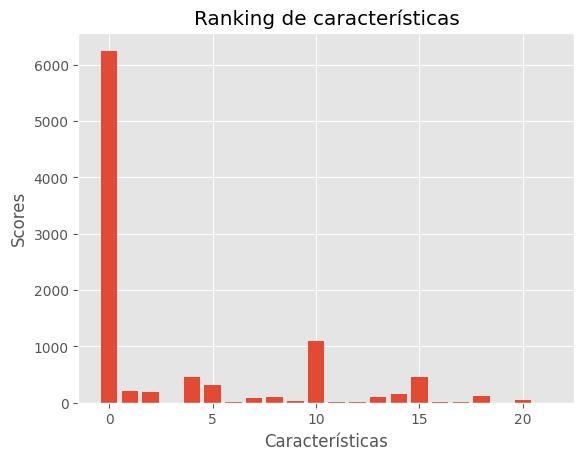

In [67]:
# Haciendo uso de los conjuntos ya transformados podemos ver el score de cada variable
# En este caso utilizamos X_train, X_test, y_train

X_train_fs, X_test_fs, fs = select_features(pd.get_dummies(X_train, drop_first = True, dtype = np.int8), y_train, pd.get_dummies(X_test, drop_first = True, dtype = np.int8), 22)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

fig, ax = plt.subplots()
ax.bar([i for i in range(len(fs.scores_))], fs.scores_)
ax.set(title='Ranking de características',xlabel='Características',ylabel='Scores')
plt.show()

In [ ]:
## DEJAR 10 VARIABLES

In [15]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [ ]:
ClfScores(dummy_clf,X_train, y_train, X_test, y_test)

**Pipelines modelos**

In [17]:
## Grid parameters for each of the models
rf_grid_params = { 'model__max_depth': [1,4,8,12,16,20],
                'model__max_features': ['sqrt'],
                'model__max_leaf_nodes': [2,4,6,8],
                'model__min_samples_leaf': [5,10,20],
                'model__min_samples_split': [2, 5, 10,20],
                'model__n_estimators': [100,200,300]}

nb_grid_params = {'model__var_smoothing': np.logspace(0,-9, num = 100)}

kn_grid_params = {'model__n_neighbors' : np.arange(1,40)}

xgb_grid_params = {'model__learning_rate': [0.01,0.03,0.1,],
                  'model__subsample'    : [1, 0.5, 0.2],
                  'model__n_estimators' : [500,1000,1500],
                  'model__max_depth'    : [None,5,7,12,15,20] }

In [18]:
## RandomForest
rf_gs = GridSearchCV(clone(pl_dict.get('RandomForest')), rf_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
rf_gs.fit(X_train, y_train)
rf_model = clone(pl_dict.get('RandomForest')).set_params(**rf_gs.best_params_)
rf_model.fit(X_train, y_train)
ClfScores(rf_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.4936788874841972
Accuracy train  :  0.510826616089774
Cohen Kappa train  :  0.3425257985244785
Cohen Kappa test  :  0.3224103966992705
Precision train  :  [0.41510695 0.40031153 0.51292247 0.60725769]
Precision test  :  [0.43342776 0.36129032 0.49494949 0.56476684]
Recall train  :  [0.40403383 0.17760885 0.65774379 0.74520857]
Recall test  :  [0.38345865 0.14698163 0.64986737 0.76941176]


In [19]:
## LogisticRegression
lr_model = clone(pl_dict.get('LogisticRegression'))
lr_model.fit(X_train, y_train)
ClfScores(lr_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.5139064475347661
Accuracy train  :  0.5158843053579896
Cohen Kappa train  :  0.3510956530147953
Cohen Kappa test  :  0.3503694147248987
Precision train  :  [0.41864407 0.40755208 0.51560021 0.65068493]
Precision test  :  [0.43678161 0.40104167 0.50425532 0.6371134 ]
Recall train  :  [0.482108   0.21630961 0.62141491 0.69616685]
Recall test  :  [0.47619048 0.20209974 0.62864721 0.72705882]


In [20]:
## NaiveBayes
nb_gs = GridSearchCV(clone(pl_dict.get('NaiveBayes')), nb_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
nb_gs.fit(X_train, y_train)
nb_model = clone(pl_dict.get('NaiveBayes')).set_params(**nb_gs.best_params_)
nb_model.fit(X_train, y_train)
ClfScores(nb_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.4949431099873578
Accuracy train  :  0.49865655128813025
Cohen Kappa train  :  0.32722667696659846
Cohen Kappa test  :  0.32554627839174954
Precision train  :  [0.44932432 0.38042131 0.46065013 0.62012012]
Precision test  :  [0.48122867 0.39215686 0.45053004 0.59152216]
Recall train  :  [0.34612882 0.2121631  0.68642447 0.69842165]
Recall test  :  [0.35338346 0.20997375 0.67639257 0.72235294]


In [21]:
## KNeighborsClassifier
kn_gs = GridSearchCV(clone(pl_dict.get('KNeighborsClassifier')), kn_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
kn_gs.fit(X_train, y_train)
kn_model = clone(pl_dict.get('KNeighborsClassifier')).set_params(**kn_gs.best_params_)
kn_model.fit(X_train, y_train)
ClfScores(kn_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.5056890012642224
Accuracy train  :  0.5448079658605974
Cohen Kappa train  :  0.39016326617354546
Cohen Kappa test  :  0.3395855554025241
Precision train  :  [0.47895792 0.44097561 0.54389722 0.65152297]
Precision test  :  [0.43902439 0.38818565 0.5154185  0.61122661]
Recall train  :  [0.46649317 0.31237042 0.64754621 0.7113867 ]
Recall test  :  [0.45112782 0.24146982 0.62068966 0.69176471]


In [ ]:
## XGBClassifier
xgb_gs = GridSearchCV(clone(pl_dict.get('XGBClassifier')), xgb_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
xgb_gs.fit(X_train, y_train)
xgb_model = clone(pl_dict.get('XGBClassifier')).set_params(**xgb_gs.best_params_)
xgb_model.fit(X_train, y_train)
ClfScores(xgb_model,X_train, y_train, X_test, y_test)

In [ ]:
xgb_model.get_params()

In [23]:
ClfScores(joblib.load('XGB_pl.joblib'),X_train, y_train, X_test, y_test)

Accuracy test  :  0.5284450063211125
Accuracy train  :  0.6707760391970918
Cohen Kappa train  :  0.559066801417676
Cohen Kappa test  :  0.36948001436093825
Precision train  :  [0.62205226 0.61929371 0.67596035 0.73524962]
Precision test  :  [0.46095718 0.41729323 0.55583127 0.61627907]
Recall train  :  [0.63500325 0.49689012 0.69534736 0.82187148]
Recall test  :  [0.45864662 0.29133858 0.59416446 0.74823529]


In [ ]:
joblib.dump(xgb_model, 'XGB_pl.joblib')

In [ ]:
## StackingClassification
estimators = [('RandomForest',clone(pl_dict.get('RandomForest')).set_params(**rf_gs.best_params_)),
              ('KNeighbors',clone(pl_dict.get('KNeighborsClassifier')).set_params(**kn_gs.best_params_)),
              ('XGBClf',clone(pl_dict.get('XGBClassifier')).set_params(**xgb_gs.best_params_))]

from sklearn.ensemble import StackingClassifier, VotingClassifier

stack_clf = StackingClassifier(estimators = estimators,
                        final_estimator = LogisticRegression())

stack_clf.fit(X_train, y_train)

ClfScores(stack_clf,X_train, y_train, X_test, y_test)

In [ ]:
vote_clf = VotingClassifier(estimators = estimators)
vote_clf.fit(X_train, y_train)

ClfScores(vote_clf,X_train, y_train, X_test, y_test)

## Reducción dimensionalidad


Considerando todas las variables, realizar un análisis de componentes principales (PCA), eligiendo el número de componentes necesarios para conservar al menos el 80% de la representación original.

In [76]:
train_pca = train.copy()

In [77]:
train_pca[target_idx] = LabelEncoder().fit_transform(train_pca[target_idx]).reshape(train_pca[target_idx].shape) ## Encode target variables
train_pca = pd.get_dummies(train_pca, dtype = np.int8, drop_first= True) ## Encode categorical variables
train_pca_std = pd.DataFrame(StandardScaler().fit_transform(train_pca), columns = train_pca.columns) ## Estandarizar variables

In [78]:
num_std = StandardScaler().fit_transform(train[num_idx])

In [ ]:
pca_num = PCA()
pca_num.fit(num_std)

<BarContainer object of 3 artists>

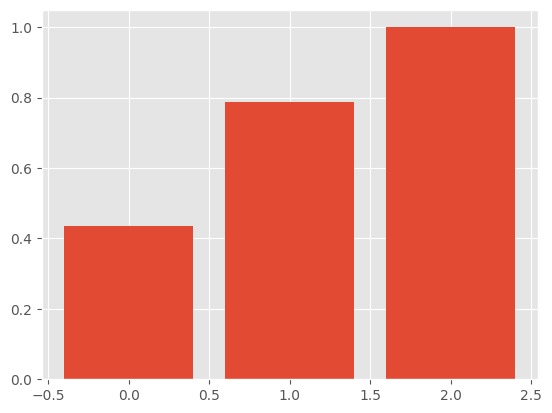

In [80]:
plt.bar(range(len(np.cumsum(pca_num.explained_variance_ratio_))),np.cumsum(pca_num.explained_variance_ratio_))

La proporción de la variable explicada con 2 componentes es muy cercana al 80% (78.6%)

In [81]:
np.cumsum(pca_num.explained_variance_ratio_)

array([0.43493016, 0.78640074, 1.        ])

In [84]:
num_idx

['Age', 'Work_Experience', 'Family_Size']

In [83]:
pca_num.components_[:2]

array([[-0.73285117,  0.31070065,  0.6053051 ],
       [-0.07914894,  0.84467525, -0.52939509]])

In [ ]:
def biplot(data, loadings, index1, index2, labels=None):
    plt.figure(figsize=(15, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1], loadings[i,index2],color='r',alpha=0.5)
        if labels is None:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1))
    plt.ylabel("PC{}".format(index2))
    plt.grid() 

## Caracterización de los clientes por segmento

KNN

DESCRIBIR LOS CLUSTER QUE SACÓ KNN